In [ ]:
pip install tensorflow==2.9.2

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import tensorboard
import datetime

kaggle = False

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
# Random seed for reproducibility
seed = 54721

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
if not kaggle:
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
if kaggle:
    train_dir = '/kaggle/input/biomedicine-data-splitted-patient/data_splitted_patient/train'
    test_dir = '/kaggle/input/biomedicine-data-splitted-patient/data_splitted_patient/test'
    val_dir = '/kaggle/input/biomedicine-data-splitted-patient/data_splitted_patient/val'
else:
    %cd /content/drive/MyDrive/data_splitted_patient
    train_dir = 'train'
    test_dir = 'test'
    val_dir = 'val'

image_size = 400 # images are 400x400x3
batch_size = 16

In [ ]:
class_names = ['N','P','T']
class_samples = [0] * len(class_names)

In [ ]:
for i, class_name in enumerate(class_names):
    class_dir = '{}/{}/'.format(train_dir, class_name)
    class_samples[i] = len(os.listdir(class_dir))

In [ ]:
total_samples = sum(class_samples)
class_weight = list(total_samples / (len(class_names) * np.array(class_samples)))
class_weight = {i: class_weight[i] for i in range(len(class_weight))}

In [ ]:
print('Class weights: {}'.format(class_weight))

Class weights: {0: 0.5512261170452836, 1: 1.2112396694214875, 2: 2.775757575757576}


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.0,
    shuffle=True,
    seed=seed,
    image_size=(image_size, image_size),
    batch_size=batch_size)

Found 10992 files belonging to 3 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    validation_split=0.0,
    shuffle=True,
    seed=seed,
    image_size=(image_size, image_size),
    batch_size=batch_size)

Found 2487 files belonging to 3 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    validation_split=0.0,
    # It doesn't matter here the shuffle -> set to False to have the heatmap
    shuffle=False,
    seed=seed,
    image_size=(image_size, image_size),
    batch_size=batch_size)

Found 1991 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("There are {} classes".format(num_classes))

There are 3 classes


In [ ]:
# Add caching to dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Use one-hot encoding for labels
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

In [ ]:
# It could be a good idea to crop just the right and the left side: they are black
crop_dim = 50
input_shape = (image_size, image_size, 3)
# Apply the corpping only in the right and left side
input_shape_cropping = (image_size, image_size-crop_dim*2, 3)

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B2(
    input_shape=input_shape_cropping,
    include_top=False,
    weights='imagenet')
base_model.trainable = True

35839040/35839040 [==============================] - 0s 0us/step


In [ ]:
model = tfk.Sequential([
    tfk.layers.Input(shape=input_shape),
    # Augmentation
    tfk.layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
    tfk.layers.RandomZoom(0.3),
    tfk.layers.RandomTranslation(width_factor=0.5, height_factor=0.5),
    tfk.layers.RandomContrast(0.1),
    tfk.layers.Cropping2D(cropping=((0, 0), (crop_dim, crop_dim)), input_shape=input_shape),

    # Preprocess for base model
    tfk.layers.Lambda(tf.keras.applications.efficientnet_v2.preprocess_input),
    # Transfer learning
    base_model,
    
    # Global avg
    tfk.layers.GlobalAveragePooling2D(),

    # Classification
    tfk.layers.Dense(512, activation='swish', kernel_initializer='he_uniform'),
    tfk.layers.Dropout(0.2),
    tfk.layers.Dense(256, activation='swish', kernel_initializer='he_uniform'),
    tfk.layers.Dropout(0.2),
    tfk.layers.Dense(192, activation='swish', kernel_initializer='he_uniform'),
    tfk.layers.Dropout(0.2),
    tfk.layers.Dense(48, activation='swish', kernel_initializer='he_uniform'),
    tfk.layers.Dropout(0.2),
    # Output
    tfk.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer=tfk.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 400, 400, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 400, 400, 3)       0         
                                                                 
 random_translation (RandomT  (None, 400, 400, 3)      0         
 ranslation)                                                     
                                                                 
 random_contrast (RandomCont  (None, 400, 400, 3)      0         
 rast)                                                           
                                                                 
 cropping2d (Cropping2D)     (None, 400, 300, 3)       0         
                                                                 
 lambda (Lambda)             (None, 400, 300, 3)       0

In [ ]:
epochs = 200

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 --yes

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weight,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=3, factor=0.5, min_lr=1e-6)
    ]).history

Epoch 1/200


2023-01-23 12:53:58.362274: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 71794992 exceeds 10% of free system memory.
2023-01-23 12:54:02.690509: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 71794992 exceeds 10% of free system memory.
2023-01-23 12:54:02.881539: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 51/687 [=>............................] - ETA: 4:56 - loss: 1.0561 - accuracy: 0.4645

2023-01-23 12:54:30.421541: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 71794992 exceeds 10% of free system memory.


 55/687 [=>............................] - ETA: 4:55 - loss: 1.0712 - accuracy: 0.4602

2023-01-23 12:54:32.298875: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 71794992 exceeds 10% of free system memory.


100/687 [===>..........................] - ETA: 4:30 - loss: 1.0022 - accuracy: 0.4569

2023-01-23 12:54:52.741362: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 71794992 exceeds 10% of free system memory.


687/687 [==============================] - 392s 532ms/step - loss: 0.8551 - accuracy: 0.5336 - val_loss: 0.8404 - val_accuracy: 0.4033 - lr: 0.0010
Epoch 2/200
687/687 [==============================] - 356s 515ms/step - loss: 0.7267 - accuracy: 0.5925 - val_loss: 0.5839 - val_accuracy: 0.7342 - lr: 0.0010
Epoch 3/200
687/687 [==============================] - 368s 534ms/step - loss: 0.6681 - accuracy: 0.6644 - val_loss: 0.7442 - val_accuracy: 0.5287 - lr: 0.0010
Epoch 4/200
687/687 [==============================] - 369s 535ms/step - loss: 0.6199 - accuracy: 0.6864 - val_loss: 0.4070 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 5/200
687/687 [==============================] - 352s 510ms/step - loss: 0.5736 - accuracy: 0.7354 - val_loss: 0.4131 - val_accuracy: 0.8295 - lr: 0.0010
Epoch 6/200
687/687 [==============================] - 351s 508ms/step - loss: 0.5489 - accuracy: 0.7439 - val_loss: 0.6250 - val_accuracy: 0.7459 - lr: 0.0010
Epoch 7/200
687/687 [==============================]

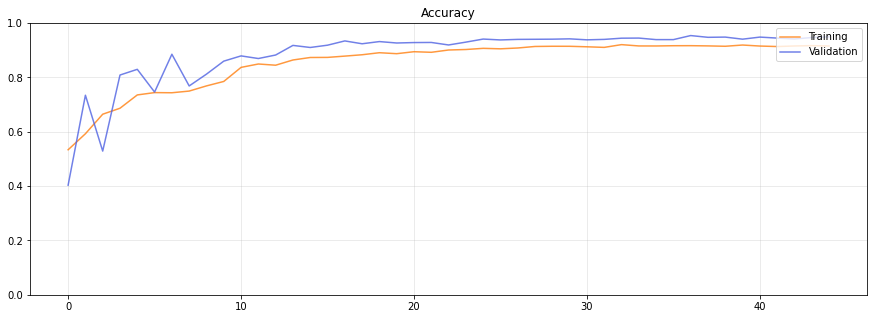

In [ ]:
import matplotlib.pyplot as plt

# plot the trend of the MSE of the training set (always decreasing of course) and of the validation set
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

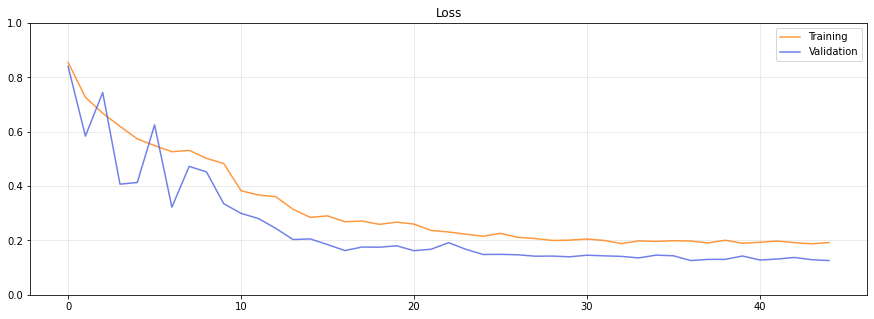

In [ ]:
import matplotlib.pyplot as plt

# plot the trend of the MSE of the training set (always decreasing of course) and of the validation set
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)
print("Loss", loss)

125/125 [==============================] - 26s 208ms/step - loss: 0.1321 - accuracy: 0.9518
Accuracy 0.9517830014228821
Loss 0.13207225501537323


In [ ]:
# Compute the prediction on the test data
predictions = model.predict(test_ds)
y_predicted = tf.argmax(predictions, axis=-1)

125/125 [==============================] - 21s 150ms/step


In [ ]:
# Take all the true labels and save them in an array
y_true =  np.array([])
count = 0
for x, y in test_ds:
    count += 1
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)])

print("There are {} images in the test set".format(count))

There are 125 images in the test set


Accuracy: 0.9518
Precision: 0.9319
Recall: 0.9328
F1: 0.9324


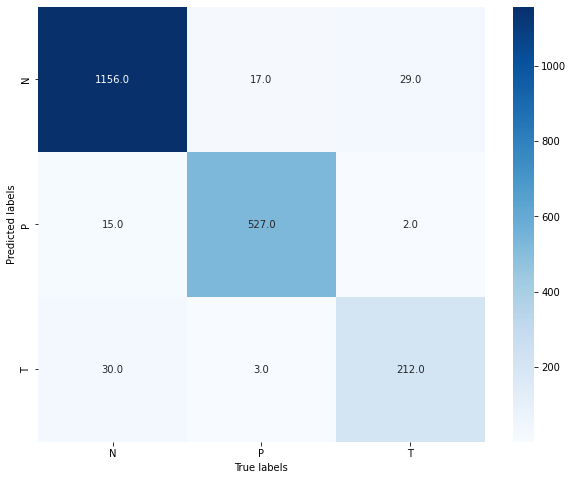

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true, y_predicted)
precision = precision_score(y_true, y_predicted, average='macro')
recall = recall_score(y_true, y_predicted, average='macro')
f1 = f1_score(y_true, y_predicted, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=class_names, yticklabels=class_names, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
if kaggle:
    %cd working
    %ls
    model.save("EfficientnetModel")
    !zip -r EfficientnetModel.zip /kaggle/working/EfficientnetModel
else:
    model.save("EfficientnetModel")